In [51]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sliderule import icesat2, earthdata
import pointCollection as pc
import datetime
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gdf=gpd.read_file('/home/jovyan/shared-public/off_track/michael/n_grn_prudhoe_lobe_ll.geojson')

print(f'gdf approx dimension:{np.sqrt(gdf.to_crs(3413).geometry[0].area)/1000} km')
poly=[]
for lon, lat in np.array(gdf.geometry[0].exterior.coords):
    poly += [{'lon':lon,'lat':lat}]
poly

gdf approx dimension:20.0000000000007 km


[{'lon': -70.41654696727473, 'lat': 78.13600815916892},
 {'lon': -69.60865799452525, 'lat': 78.21327757855809},
 {'lon': -69.24141708892685, 'lat': 78.04690041425621},
 {'lon': -70.04045074643126, 'lat': 77.970729027503},
 {'lon': -70.41654696727473, 'lat': 78.13600815916892}]

In [4]:

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL06', polygon=poly)
print(len(granules_list))

HTTP Request Error: Bad Request
Using simplified polygon (for CMR request only!), 6 points using tolerance of 0.0001


282


In [5]:

parms_06 = {
        "poly":poly}
# run sliderule
D_06 = icesat2.atl06sp(parms_06, resources=granules_list).to_crs(3413)


In [6]:
print(f"originally found data with shape: {D_06.shape}")
D_06=D_06[D_06.atl06_quality_summary==0]
print(f"after subsetting, found data with shape: {D_06.shape}")


originally found data with shape: (681809, 21)
after subsetting, found data with shape: (628478, 21)


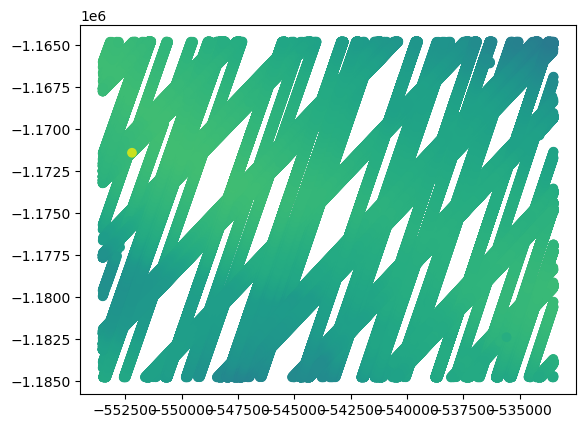

In [7]:
plt.figure()
plt.scatter(D_06.geometry.x, D_06.geometry.y, c=D_06.h_li)

In [70]:
# make a pointCollection.data object containing a subset of the data
# we will rename the h_li field to 'z' and the 'h_li_sigma' field to 'sigma'
D_full=pc.data().from_dict({field:np.array(D_06[field]) for field in ['spot','rgt','cycle','gt']})
D_full.assign({'x':np.array(D_06.geometry.x),
          'y':np.array(D_06.geometry.y), 
               'z':np.array(D_06.h_li),
               'sigma':np.array(D_06.h_li_sigma),
         't':np.array(D_06.index-datetime.datetime(2018, 1, 1)).astype(float)/1.e9/24/3600/365.25+2018})



<class 'pointCollection.data.data'> with shape (628478,),
with fields:
['spot', 'rgt', 'cycle', 'gt', 'x', 'y', 'z', 'sigma', 't']

In [71]:
# reduce the data resolution to 80 m with a block median

_,rc_ind=pc.unique_by_rows(np.c_[D_full.cycle, D_full.rgt], return_dict=True)

D=[]
for rc, ind in rc_ind.items():
    D += [D_full[ind].blockmedian(80, 'z')]
D=pc.data().from_list(D)
print(D.summary())

field 	shape 	n_finite 	STD 	 minmax
spot	(179838,)	179838	1.71e+00	1.00e+00 6.00e+00
rgt	(179838,)	179838	3.91e+02	1.10e+02 1.29e+03
cycle	(179838,)	179838	6.61e+00	1.00e+00 2.30e+01
gt	(179838,)	179838	1.71e+01	1.00e+01 6.00e+01
x	(179838,)	179838	5.81e+03	-5.53e+05 -5.34e+05
y	(179838,)	179838	5.82e+03	-1.18e+06 -1.16e+06
z	(179838,)	179838	7.67e+01	4.66e+02 1.70e+03
sigma	(179838,)	179838	5.29e-02	4.54e-03 9.99e-01
t	(179838,)	179838	1.64e+00	2.02e+03 2.02e+03


In [73]:
D.to_h5('../shared/staged_data/ATL06_n_grn_prudhoe_lobe.h5')